In [1]:
# Data imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# read data
df = pd.read_csv("apis/tweet_data.csv")

# sample data
df = df.sample(frac=1).reset_index(drop=True)

# clean tweet text
df['Text'] = df['Text'].apply(lambda x: x.lower())  # transform text to lowercase
df['Text'] = df['Text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
print(df.shape)
df.head(10)

(5791, 2)


,Text,Sentiment
0,sensex opens 1564 points lower nifty starts da...,-1
1,while the new 350 billion paycheck protection ...,-1
2,aap loading up on jan 2015s 440 strikes 62 7 ...,1
3,pat one es spy update,-1
4,green weekly triangle on jbopen ong at 679,1
5,gmx taking more off here 389,1
6,expect nfx to trade higher on dish founders po...,1
7,both ma and v should be on everyones watch lis...,1
8,cat bingo it is bingo everywhere today,1
9,bac here comes another push higher jpm calls b...,1


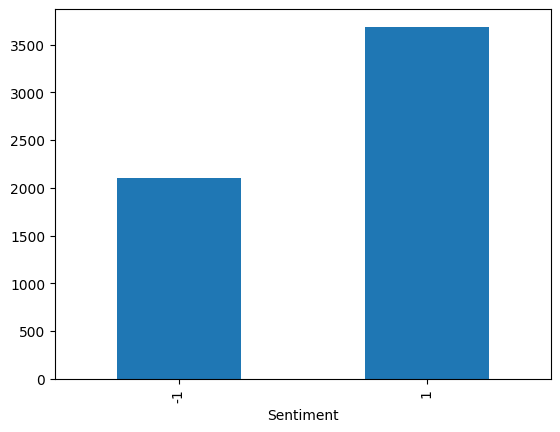

In [3]:
df['Sentiment'].value_counts().sort_index().plot.bar()
plt.savefig("images/single_count.png")

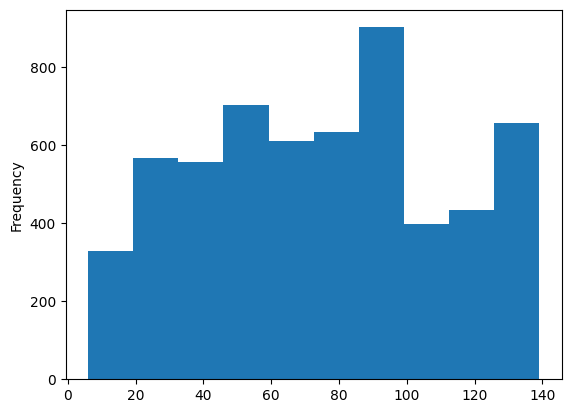

In [4]:
df['Text'].str.len().plot.hist()
plt.savefig("images/tweet_len.png")

In [5]:
# X as tokenize data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['Text'].values)
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X)
print("X tokenized data = ", X[:5])


X tokenized data =  [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   73  376 3238   99  100   81  477   31
    12 3239 3240]
 [   0    0    0    0    0    0    0    0    0    0    0  370    1   47
   625  383 3241 3242 1553   10 3243   12  720   20  299   75 2065  880
    88  573 4776]
 [   0    0    0    0    0    0    0    0    8 3244   17    4  361 2530
  1123 1554 2531  392  496    7    1  109    6  309  145  340   18   13
    22    5 2066]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0 3245   72
   247  138  687]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   98   84   74    4 4777
    71   12 4778]]


In [6]:
# Y as buckets of Sentiment column
y = pd.get_dummies(df['Sentiment']).values
[print(df['Sentiment'][i], y[i]) for i in range(0, 5)]

-1 [ True False]
-1 [ True False]
1 [False  True]
-1 [ True False]
1 [False  True]


[None, None, None, None, None]

In [7]:
# lstm create model
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(GRU(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 31, 256)           1280000   
                                                                 
 dropout (Dropout)           (None, 31, 256)           0         
                                                                 
 gru (GRU)                   (None, 31, 256)           394752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 2,070,018
Trainable params: 2,070,018
Non-trainable params: 0
_________________________________________________________________


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
batch_size = 32
epochs = 8

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/8
145/145 - 91s - loss: 0.5789 - accuracy: 0.7032 - 91s/epoch - 629ms/step
Epoch 2/8
145/145 - 70s - loss: 0.3804 - accuracy: 0.8314 - 70s/epoch - 479ms/step
Epoch 3/8
145/145 - 74s - loss: 0.2237 - accuracy: 0.9080 - 74s/epoch - 510ms/step
Epoch 4/8
145/145 - 87s - loss: 0.1480 - accuracy: 0.9434 - 87s/epoch - 597ms/step
Epoch 5/8
145/145 - 81s - loss: 0.0823 - accuracy: 0.9724 - 81s/epoch - 558ms/step
Epoch 6/8
145/145 - 83s - loss: 0.0477 - accuracy: 0.9829 - 83s/epoch - 575ms/step
Epoch 7/8
145/145 - 74s - loss: 0.0405 - accuracy: 0.9860 - 74s/epoch - 509ms/step
Epoch 8/8
145/145 - 79s - loss: 0.0395 - accuracy: 0.9851 - 79s/epoch - 545ms/step


In [11]:
predictions = model.predict(X_test)

37/37 [==============================] - 4s 77ms/step


In [12]:
pos_count, neg_count = 0, 0
real_pos, real_neg = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==1:
        pos_count += 1
    else:
        neg_count += 1
    if np.argmax(y_test[i])==1:    
        real_pos += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Negative predictions:', neg_count)

print('Real neutral:', real_pos)
print('Real negative:', real_neg)

Positive predictions: 756
Negative predictions: 403
Real neutral: 736
Real negative: 423


In [13]:
import matplotlib.pyplot as plt

In [14]:
print(history.history['loss'], )
predictions = [pos_count, neg_count]
real = [real_pos, real_neg]
labels = ['Positive', 'Negative']

[0.5788701772689819, 0.3803689479827881, 0.22372283041477203, 0.14795193076133728, 0.08230870217084885, 0.04771771281957626, 0.04053236171603203, 0.039484258741140366]


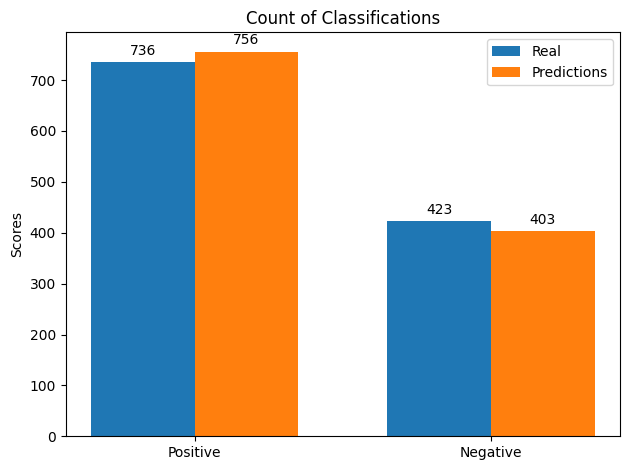

In [15]:
x = np.arange(len(labels))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, real, width, label='Real')
rects2 = ax.bar(x + width/2, predictions, width, label='Predictions')

ax.set_ylabel('Scores')
ax.set_title('Count of Classifications')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.savefig("images/predictions_gru.png")
plt.show()

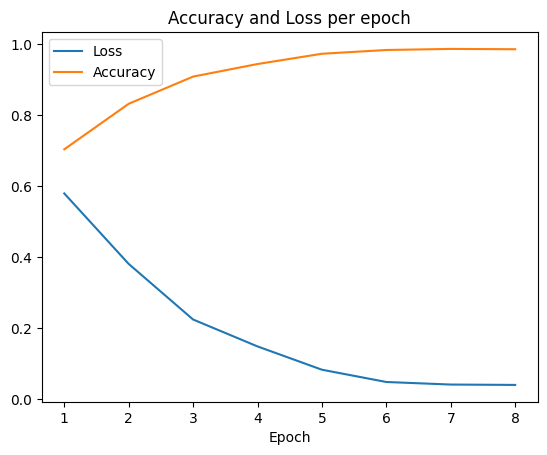

In [16]:
fig, ax = plt.subplots()
loss = history.history['loss']
epoch = [item for item in range(1,9)]
accuracy = history.history['accuracy']
ax.plot(epoch, loss, label = "Loss")
ax.plot(epoch, accuracy, label = "Accuracy")

ax.set_xlabel('Epoch')
ax.set_title('Accuracy and Loss per epoch')
plt.legend()
plt.savefig("images/epoch_gru.png")
plt.show()